In [ ]:
# Importar librerías
!pip install peft
!pip install evaluate
!pip install iterative-stratification

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00


In [ ]:
# Importar essays dataset

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/datos/
import pandas as pd

df = pd.read_csv('essays_dataset.csv', sep = ";", encoding="ISO-8859-1")
cols = df.columns
label_cols = list(cols[2:])
num_labels = len(label_cols)
df['one_hot_labels'] = list(df[label_cols].values)
df = df.sample(frac=1).reset_index(drop=True) #barajar filas
df.head()

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1cS-a87Vv86JJ9nAOco8EjgbQ3ocNrK_i/datos


,ï»¿ID,TEXT,EXT,NEU,AGR,CON,OPN,one_hot_labels
0,2004_382.txt,Sleep! That's what I need to do. I stayed up a...,1,0,1,1,1,"[1, 0, 1, 1, 1]"
1,1999_896204.txt,I think this is a really cool writing assignme...,1,0,1,1,0,"[1, 0, 1, 1, 0]"
2,2002_730158.txt,My roommate is throwing gummy bears at me. My ...,0,1,1,0,1,"[0, 1, 1, 0, 1]"
3,2002_877267.txt,I've been thinking about relationships lately....,1,0,1,1,1,"[1, 0, 1, 1, 1]"
4,1998_857967.txt,I know that I have assignments to take care of...,0,1,1,0,0,"[0, 1, 1, 0, 0]"


In [ ]:
# Importar librerías
import argparse
import os
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    LoraConfig,
    PeftType,
    PrefixTuningConfig,
    PromptEncoderConfig,
)

import evaluate
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup, set_seed
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from datasets import Dataset
import torch
import numpy as np
import random
import torch
from torch.nn import BCEWithLogitsLoss
from tqdm import trange
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import roc_auc_score
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
from transformers import RobertaForSequenceClassification
from torch.optim import Adam, Adagrad
from transformers import RobertaTokenizer

In [ ]:
cols = df.columns
df = df.sample(frac=1).reset_index(drop=True) #barajar filas
df.head()

,ï»¿ID,TEXT,EXT,NEU,AGR,CON,OPN,one_hot_labels
0,2002_075063.txt,Cars Mileyva sock bigsteakhouse hands car prin...,0,1,1,0,0,"[0, 1, 1, 0, 0]"
1,2002_750740.txt,This seems kind of odd to sit and write to a c...,0,1,0,0,1,"[0, 1, 0, 0, 1]"
2,1998_172542.txt,I don't like people to know how my mind works ...,0,1,1,1,1,"[0, 1, 1, 1, 1]"
3,2000_940609.txt,I swear that office space is the funniest movi...,1,0,1,1,1,"[1, 0, 1, 1, 1]"
4,1997_743186.txt,"Okay, Iâm not so sure where to begin. only t...",1,1,0,1,1,"[1, 1, 0, 1, 1]"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2467 entries, 0 to 2466
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ï»¿ID           2467 non-null   object
 1   TEXT            2467 non-null   object
 2   EXT             2467 non-null   int64 
 3   NEU             2467 non-null   int64 
 4   AGR             2467 non-null   int64 
 5   CON             2467 non-null   int64 
 6   OPN             2467 non-null   int64 
 7   one_hot_labels  2467 non-null   object
dtypes: int64(5), object(3)
memory usage: 154.3+ KB


In [ ]:
#configuracion previa (ajuste loRA)
model_name_or_path = "roberta-large"
peft_type = PeftType.LORA
peft_config = LoraConfig(task_type="SEQ_CLS", inference_mode=False, r=8, lora_alpha=16, lora_dropout=0.1)

# Definir el nombre de las columnas del dataset
column_names = ['TEXT', 'EXT', 'NEU', 'AGR', 'CON', 'OPN', 'one_hot_labels']

# Convertir el dataframe en un diccionario
data = {
    column: df[column].tolist()
    for column in column_names
}

# Crear el dataset de Hugging Face
dataset = Dataset.from_dict(data)

if any(k in model_name_or_path for k in ("gpt", "opt", "bloom")):
    padding_side = "left"
else:
    padding_side = "right"

In [ ]:
#tokenizacion
tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path, padding_side=padding_side)
if getattr(tokenizer, "pad_token_id") is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
def tokenize_function(examples):
        outputs = tokenizer(examples["TEXT"], truncation=True, max_length=512)
        return outputs
tokenized_datasets = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["TEXT", "EXT", "NEU","AGR", "CON", "OPN"],
)
tokenized_datasets = tokenized_datasets.rename_column("one_hot_labels", "labels")
def collate_fn(examples):
    return tokenizer.pad(examples, padding='longest', return_tensors="pt")

Map:   0%|          | 0/2467 [00:00<?, ? examples/s]

Fold: 1/5
Train index: [   0    1    2 ... 2464 2465 2466]
Eval index: [   3   19   23   28   29   35   37   40   43   54   55   61   65   73
   77   83   86  103  108  109  112  117  128  135  138  142  147  155
  157  158  159  163  164  176  185  190  196  197  201  205  210  216
  223  225  233  238  240  241  247  252  254  260  266  278  281  289
  291  294  300  305  306  308  313  316  318  324  330  331  335  338
  352  363  376  380  391  392  405  408  409  410  413  415  417  421
  428  439  459  461  462  470  473  475  477  482  484  487  490  493
  499  502  508  511  513  523  536  546  556  562  578  580  581  584
  589  605  613  614  615  632  640  641  648  650  651  652  656  661
  670  673  679  681  690  701  708  713  716  724  726  733  736  742
  750  754  768  769  772  784  788  791  795  796  803  805  807  809
  813  823  827  829  831  834  839  845  851  853  855  859  864  875
  876  880  883  886  888  897  903  911  913  918  919  925  928  937
  948 

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,895,882 || all params: 357,206,026 || trainable%: 0.8107035685898535
Epoch: 1/4
Train Loss: 0.6994
Eval Loss: 0.7042
AUC: 0.5796
              precision    recall  f1-score   support

           0       0.53      0.90      0.67       255
           1       0.00      0.00      0.00       247
           2       0.54      1.00      0.70       262
           3       0.51      1.00      0.68       251
           4       0.59      0.80      0.68       254

   micro avg       0.54      0.74      0.63      1269
   macro avg       0.43      0.74      0.55      1269
weighted avg       0.44      0.74      0.55      1269
 samples avg       0.54      0.69      0.59      1269



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2/4
Train Loss: 0.6836
Eval Loss: 0.6689
AUC: 0.6236
              precision    recall  f1-score   support

           0       0.63      0.40      0.49       255
           1       0.58      0.66      0.61       247
           2       0.62      0.62      0.62       262
           3       0.56      0.60      0.58       251
           4       0.65      0.66      0.65       254

   micro avg       0.60      0.59      0.60      1269
   macro avg       0.61      0.59      0.59      1269
weighted avg       0.61      0.59      0.59      1269
 samples avg       0.61      0.56      0.54      1269



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3/4
Train Loss: 0.6539
Eval Loss: 0.6706
AUC: 0.6297
              precision    recall  f1-score   support

           0       0.60      0.64      0.62       255
           1       0.60      0.50      0.55       247
           2       0.57      0.92      0.70       262
           3       0.58      0.49      0.53       251
           4       0.68      0.60      0.64       254

   micro avg       0.60      0.63      0.62      1269
   macro avg       0.61      0.63      0.61      1269
weighted avg       0.61      0.63      0.61      1269
 samples avg       0.59      0.60      0.56      1269



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4/4
Train Loss: 0.6252
Eval Loss: 0.6844
AUC: 0.6291
              precision    recall  f1-score   support

           0       0.61      0.49      0.54       255
           1       0.60      0.54      0.57       247
           2       0.60      0.66      0.63       262
           3       0.58      0.60      0.59       251
           4       0.75      0.52      0.62       254

   micro avg       0.62      0.56      0.59      1269
   macro avg       0.63      0.56      0.59      1269
weighted avg       0.63      0.56      0.59      1269
 samples avg       0.60      0.54      0.53      1269

Fold: 2/5
Train index: [   0    1    3 ... 2463 2464 2466]
Eval index: [   2    8   21   27   36   39   46   57   62   69   78   84   87   89
   90   93   95   97  101  107  110  111  114  116  119  129  130  131
  140  149  151  156  162  166  167  168  171  173  175  184  188  204
  208  215  219  222  226  230  244  245  253  255  256  275  277  282
  288  295  298  307  309  314  321  323  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,895,882 || all params: 357,206,026 || trainable%: 0.8107035685898535
Epoch: 1/4
Train Loss: 0.7062
Eval Loss: 0.7014
AUC: 0.5908
              precision    recall  f1-score   support

           0       0.52      1.00      0.69       256
           1       0.50      1.00      0.67       247
           2       0.54      1.00      0.70       262
           3       0.62      0.02      0.04       251
           4       0.52      1.00      0.68       254

   micro avg       0.52      0.81      0.63      1270
   macro avg       0.54      0.80      0.56      1270
weighted avg       0.54      0.81      0.56      1270
 samples avg       0.52      0.78      0.60      1270



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2/4
Train Loss: 0.6905
Eval Loss: 0.6780
AUC: 0.6218
              precision    recall  f1-score   support

           0       0.59      0.69      0.63       256
           1       0.56      0.22      0.32       247
           2       0.63      0.63      0.63       262
           3       0.52      0.94      0.67       251
           4       0.67      0.51      0.58       254

   micro avg       0.58      0.60      0.59      1270
   macro avg       0.59      0.60      0.57      1270
weighted avg       0.59      0.60      0.57      1270
 samples avg       0.57      0.57      0.54      1270



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3/4
Train Loss: 0.6754
Eval Loss: 0.6639
AUC: 0.6480
              precision    recall  f1-score   support

           0       0.61      0.80      0.69       256
           1       0.57      0.65      0.61       247
           2       0.65      0.59      0.62       262
           3       0.59      0.53      0.56       251
           4       0.69      0.40      0.51       254

   micro avg       0.62      0.59      0.60      1270
   macro avg       0.62      0.59      0.60      1270
weighted avg       0.62      0.59      0.60      1270
 samples avg       0.60      0.58      0.54      1270



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4/4
Train Loss: 0.6510
Eval Loss: 0.6626
AUC: 0.6460
              precision    recall  f1-score   support

           0       0.64      0.75      0.69       256
           1       0.58      0.58      0.58       247
           2       0.60      0.72      0.65       262
           3       0.58      0.57      0.57       251
           4       0.68      0.57      0.62       254

   micro avg       0.61      0.64      0.63      1270
   macro avg       0.62      0.64      0.62      1270
weighted avg       0.62      0.64      0.63      1270
 samples avg       0.60      0.62      0.57      1270

Fold: 3/5
Train index: [   2    3    4 ... 2462 2463 2465]
Eval index: [   0    1   10   17   20   24   25   26   42   47   48   63   71   92
   96   99  105  106  118  120  124  134  137  141  143  144  148  160
  165  180  181  191  192  193  200  206  207  209  212  213  224  228
  229  231  237  242  248  249  250  257  264  272  279  284  290  292
  293  297  302  303  304  310  311  315  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,895,882 || all params: 357,206,026 || trainable%: 0.8107035685898535
Epoch: 1/4
Train Loss: 0.7001
Eval Loss: 0.6986
AUC: 0.5947
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       255
           1       0.53      0.75      0.62       246
           2       0.53      1.00      0.69       262
           3       0.51      0.99      0.67       250
           4       0.51      1.00      0.68       254

   micro avg       0.52      0.95      0.67      1267
   macro avg       0.52      0.95      0.67      1267
weighted avg       0.52      0.95      0.67      1267
 samples avg       0.52      0.94      0.64      1267

Epoch: 2/4
Train Loss: 0.6869
Eval Loss: 0.6726
AUC: 0.6272
              precision    recall  f1-score   support

           0       0.53      0.88      0.66       255
           1       0.64      0.28      0.39       246
           2       0.56      0.76      0.64       262
           3       0.55      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4/4
Train Loss: 0.6326
Eval Loss: 0.6727
AUC: 0.6393
              precision    recall  f1-score   support

           0       0.58      0.66      0.62       255
           1       0.63      0.52      0.57       246
           2       0.60      0.70      0.65       262
           3       0.59      0.58      0.59       250
           4       0.67      0.54      0.59       254

   micro avg       0.61      0.60      0.61      1267
   macro avg       0.61      0.60      0.60      1267
weighted avg       0.61      0.60      0.60      1267
 samples avg       0.59      0.59      0.55      1267

Fold: 4/5
Train index: [   0    1    2 ... 2464 2465 2466]
Eval index: [   4    5    7    9   11   12   14   16   22   30   32   38   41   45
   50   53   59   60   66   68   75   76   80   82   94   98  100  102
  113  115  121  123  126  133  136  146  150  153  169  170  172  178
  179  182  187  189  195  198  227  232  234  236  239  243  246  258
  259  261  262  267  269  270  271  276  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,895,882 || all params: 357,206,026 || trainable%: 0.8107035685898535
Epoch: 1/4
Train Loss: 0.7031
Eval Loss: 0.6913
AUC: 0.5908
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       255
           1       0.52      0.89      0.65       247
           2       0.52      1.00      0.68       262
           3       0.62      0.16      0.25       250
           4       0.71      0.11      0.20       254

   micro avg       0.52      0.64      0.57      1268
   macro avg       0.57      0.63      0.49      1268
weighted avg       0.57      0.64      0.49      1268
 samples avg       0.52      0.65      0.55      1268

Epoch: 2/4
Train Loss: 0.6857
Eval Loss: 0.6790
AUC: 0.6125
              precision    recall  f1-score   support

           0       0.52      0.98      0.68       255
           1       0.58      0.56      0.57       247
           2       0.55      0.81      0.65       262
           3       0.57      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3/4
Train Loss: 0.6614
Eval Loss: 0.6771
AUC: 0.6167
              precision    recall  f1-score   support

           0       0.53      0.77      0.63       255
           1       0.59      0.57      0.58       247
           2       0.56      0.68      0.62       262
           3       0.56      0.65      0.60       250
           4       0.71      0.46      0.56       254

   micro avg       0.57      0.63      0.60      1268
   macro avg       0.59      0.63      0.60      1268
weighted avg       0.59      0.63      0.60      1268
 samples avg       0.55      0.63      0.55      1268



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4/4
Train Loss: 0.6354
Eval Loss: 0.6891
AUC: 0.6190
              precision    recall  f1-score   support

           0       0.56      0.62      0.59       255
           1       0.60      0.55      0.58       247
           2       0.55      0.82      0.66       262
           3       0.54      0.76      0.63       250
           4       0.68      0.46      0.55       254

   micro avg       0.57      0.64      0.61      1268
   macro avg       0.59      0.64      0.60      1268
weighted avg       0.59      0.64      0.60      1268
 samples avg       0.57      0.64      0.56      1268

Fold: 5/5
Train index: [   0    1    2 ... 2464 2465 2466]
Eval index: [   6   13   15   18   31   33   34   44   49   51   52   56   58   64
   67   70   72   74   79   81   85   88   91  104  122  125  127  132
  139  145  152  154  161  174  177  183  186  194  199  202  203  211
  214  217  218  220  221  235  251  263  265  268  273  274  280  283
  286  287  296  299  301  312  320  340  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,895,882 || all params: 357,206,026 || trainable%: 0.8107035685898535
Epoch: 1/4
Train Loss: 0.7027
Eval Loss: 0.6898
AUC: 0.6044
              precision    recall  f1-score   support

           0       0.52      1.00      0.69       255
           1       0.50      1.00      0.67       246
           2       0.54      1.00      0.70       262
           3       0.52      1.00      0.68       251
           4       0.56      0.88      0.69       255

   micro avg       0.53      0.98      0.68      1269
   macro avg       0.53      0.98      0.68      1269
weighted avg       0.53      0.98      0.68      1269
 samples avg       0.53      0.94      0.65      1269



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2/4
Train Loss: 0.6913
Eval Loss: 0.6751
AUC: 0.6361
              precision    recall  f1-score   support

           0       0.58      0.85      0.69       255
           1       0.53      0.81      0.65       246
           2       0.60      0.76      0.67       262
           3       0.54      0.90      0.67       251
           4       0.78      0.25      0.38       255

   micro avg       0.57      0.71      0.63      1269
   macro avg       0.61      0.71      0.61      1269
weighted avg       0.61      0.71      0.61      1269
 samples avg       0.55      0.68      0.58      1269



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3/4
Train Loss: 0.6682
Eval Loss: 0.6622
AUC: 0.6375
              precision    recall  f1-score   support

           0       0.60      0.66      0.63       255
           1       0.60      0.54      0.57       246
           2       0.61      0.66      0.64       262
           3       0.56      0.65      0.61       251
           4       0.69      0.55      0.61       255

   micro avg       0.61      0.61      0.61      1269
   macro avg       0.62      0.61      0.61      1269
weighted avg       0.62      0.61      0.61      1269
 samples avg       0.60      0.58      0.55      1269



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4/4
Train Loss: 0.6468
Eval Loss: 0.6701
AUC: 0.6340
              precision    recall  f1-score   support

           0       0.61      0.66      0.63       255
           1       0.58      0.63      0.61       246
           2       0.60      0.74      0.66       262
           3       0.57      0.66      0.61       251
           4       0.73      0.44      0.55       255

   micro avg       0.61      0.63      0.62      1269
   macro avg       0.62      0.63      0.61      1269
weighted avg       0.62      0.63      0.61      1269
 samples avg       0.59      0.59      0.55      1269



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


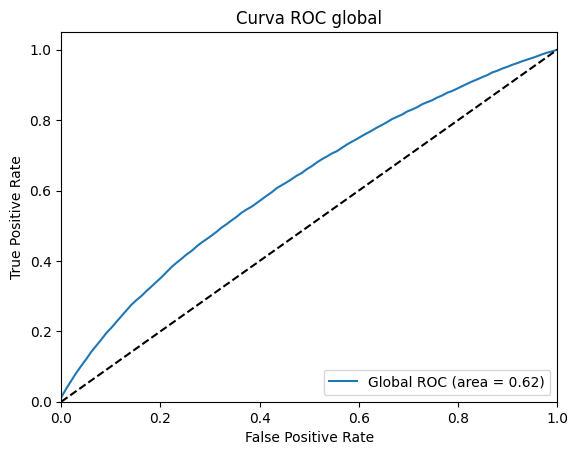

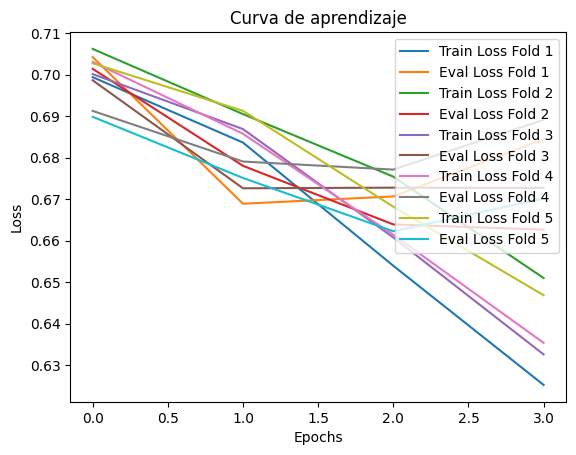

In [ ]:
# Instrucciones de arquitectura y procesamiento
k = 5
kf = MultilabelStratifiedKFold(n_splits=k, shuffle=True, random_state=42)

X = tokenized_datasets["input_ids"]
y = tokenized_datasets["labels"]

all_fpr = []
all_tpr = []
all_roc_auc = []

train_losses = []
eval_losses = []

for fold, (train_index, eval_index) in enumerate(kf.split(X, y)):
    print(f'Fold: {fold + 1}/{k}')
    print(f'Train index: {train_index}')
    print(f'Eval index: {eval_index}')
    device = "cuda"
    num_epochs = 4
    batch_size = 1
    lr = 5e-5
    seed = 42
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    num_labels=5
    model = RobertaForSequenceClassification.from_pretrained("roberta-large", num_labels=num_labels)
    model.task_name = "classification"
    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()
    model.cuda()
    train_dataset = tokenized_datasets.select(train_index)
    eval_dataset = tokenized_datasets.select(eval_index)
    train_dataloader = DataLoader(train_dataset, shuffle=True, collate_fn=collate_fn, batch_size=batch_size)
    eval_dataloader = DataLoader(eval_dataset, shuffle=False, collate_fn=collate_fn, batch_size=batch_size)

    # Optimizador
    # Definir el optimizador como Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # Crear una instancia scheduler
    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=0.06 * (len(train_dataloader) * num_epochs),
        num_training_steps=(len(train_dataloader) * num_epochs),
    )

    epoch_train_losses = []
    epoch_eval_losses = []


    # Definir la función de pérdida como entropía cruzada sigmoide
    loss_fn = torch.nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        # Entrenamiento
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].float().to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        # Evaluación
        model.eval()
        eval_loss = 0
        fold_preds = []
        fold_labels = []
        with torch.no_grad():
            for batch in eval_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].float().to(device)
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = loss_fn(outputs.logits, labels)
                eval_loss += loss.item()

                preds = torch.sigmoid(outputs.logits).cpu().numpy()
                fold_preds.append(preds)
                fold_labels.append(labels.cpu().numpy())

        eval_loss /= len(eval_dataloader)

        epoch_train_losses.append(train_loss)
        epoch_eval_losses.append(eval_loss)

        fold_preds = np.concatenate(fold_preds, axis=0)
        fold_labels = np.concatenate(fold_labels, axis=0)

        auc_score = roc_auc_score(fold_labels, fold_preds, average='macro')

        print(f'Epoch: {epoch + 1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Eval Loss: {eval_loss:.4f}')
        print(f'AUC: {auc_score:.4f}')
        print(classification_report(fold_labels, fold_preds.round()))

        # Calcular la curva ROC y el área bajo la curva para cada clase
        n_classes = fold_labels.shape[1]
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(fold_labels[:, i], fold_preds[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        all_fpr.append(fpr)
        all_tpr.append(tpr)
        all_roc_auc.append(roc_auc)

    train_losses.append(epoch_train_losses)
    eval_losses.append(epoch_eval_losses)

# Trazar la curva ROC global para todas las épocas y pliegues
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)
for fpr, tpr in zip(all_fpr, all_tpr):
    for i in range(n_classes):
        mean_tpr += np.interp(mean_fpr, fpr[i], tpr[i])
mean_tpr /= (k * num_epochs * n_classes)
roc_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, label=f'Global ROC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC global')
plt.legend(loc="lower right")

# Trazar la curva de aprendizaje
plt.figure()
for i in range(k):
    plt.plot(train_losses[i], label=f'Train Loss Fold {i+1}')
    plt.plot(eval_losses[i], label=f'Eval Loss Fold {i+1}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Curva de aprendizaje')
plt.legend(loc="upper right")
plt.show()

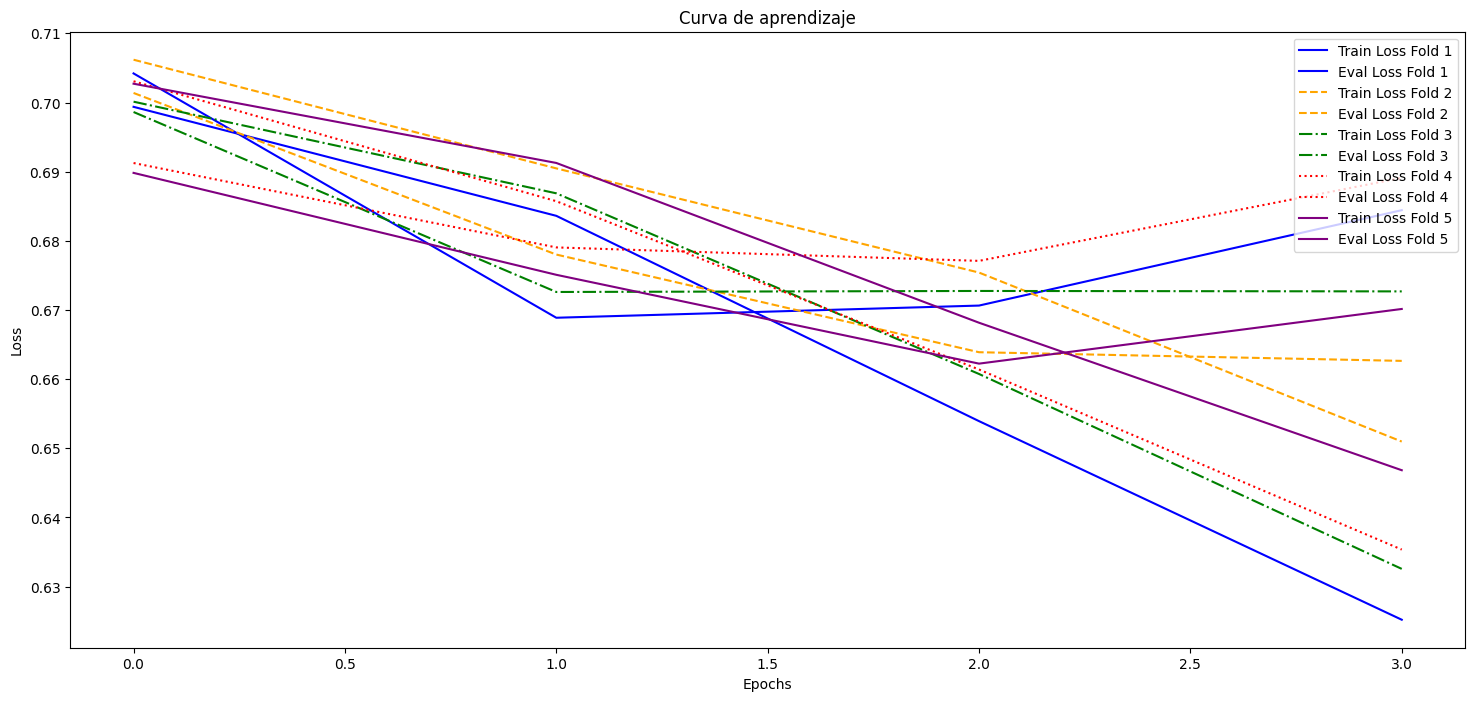

In [ ]:
# Curva de aprendizaje
plt.figure(figsize=(18, 8))
colors = ['blue', 'orange', 'green', 'red', 'purple']
linestyles = ['-', '--', '-.', ':', '-']
for i in range(k):
    plt.plot(train_losses[i], label=f'Train Loss Fold {i+1}', color=colors[i], linestyle=linestyles[i])
    plt.plot(eval_losses[i], label=f'Eval Loss Fold {i+1}', color=colors[i], linestyle=linestyles[i])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Curva de aprendizaje')
plt.legend(loc="upper right")
plt.show()

In [ ]:
# Guardar los pesos del modelo
torch.save(model.state_dict(), 'modelo_5_rasgos.pt')